# Однослойный перцептрон
Демонстрация с цветочком

In [1]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [2]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):
        
        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]
        
        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)
        
        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))
        
        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []
        
    def learn(self, iter_num, learning_rate):
        
        # Итерируемся необходимое количество раз
        for i in range(iter_num):
            
            # Расчет взыешенных сумм каждого из нейронов, применение функций активации
            # Для того, чтобы заменить функции активации, необходимо заменить функцию при вычислении А1/А2
            Z1 = np.dot(self.W1, self.X) + self.b1                                     # (hidden_size, X.shape[1])
            A1 = tanh(Z1)
            Z2 = np.dot(self.W2, A1) + self.b2                                         # (Y.shape[0], X.shape[1] = Y.shape[1])
            A2 = sigmoid(Z2)

            # Среднеквадратичная (MSE) функция потерь
            mse_loss = np.sum((A2 - self.Y) ** 2) / self.m
            
            # Cross entropy функция потерь
            eps = 1e-8
            logprobs = self.Y * np.log(A2 + eps) + (1 - self.Y) * np.log(1 - A2 + eps)
            ce_loss = (-1 / self.m) * np.sum(logprobs)
            
            # Запоминание значения функции потерь и печать на каждой 1000-й итерации
            self.mse_loss.append(mse_loss)
            self.ce_loss.append(ce_loss)
            if i % 1000 == 0: print(f"MSE loss: {mse_loss}, CE loss: {ce_loss}")

            # Алгоритм обратного распространения ошибки
            # Производные высчитываются по правилу производной для сложной функции
            # Оптимизируется среднеквадратичная функция потерь
            # Для оптимизации cross entropy необходимо заменить производную функции потерь по A2 - self.Y
            # Для этого необходимо найти dError/dW
            # При замене функций активации необходимо также заменить соответствующую ей производную
            dA2 = (A2 - self.Y) * dsigmoid(A2)        # dLoss/dA * dSig/dZ2            # (Y.shape[0], Y.shape[1] = X.shape[1])
            dW2 = np.dot(dA2, A1.T)                   # dZ2/dW2                        # (Y.shape[0], hidden_size)
            db2 = np.sum(dA2, axis=1, keepdims=True)                                   # (Y.shape[0], 1)
            dA1 = np.dot(self.W2.T, dA2) * dtanh(A1)  # dA2 * dZ2/dA1 * dTanh/dZ       # (hidden_size, Y.shape[1] = X.shape[1])
            dW1 = np.dot(dA1, self.X.T)               # dZ1/dW                         # (hidden_size, X.shape[0])
            db1 = np.sum(dA1, axis=1, keepdims=True)                                   # (hidden_size, 1)
            
            # Обновление весов методом градиентного спуска
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            
    def predict(self, X):
        # Используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)
    
    def plot(self):
        plt.figure(figsize=(10,3))
        plt.subplot(1, 2, 1)
        plt.ylabel('MSE loss')
        plt.xlabel('Iterations')
        plt.plot(self.mse_loss)
        plt.subplot(1, 2, 2)
        plt.ylabel('CE loss')
        plt.xlabel('Iterations')
        plt.plot(self.ce_loss)

## Разделение цветочка

In [3]:
# Создать датасет в виде цветочка, m - кол-во объектов (целое больше 1), a - максимальная длина листа (float больше 0)
def create_flower(m, a):
    D = 2
    N = int(m/2)
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    return X.T, Y.T

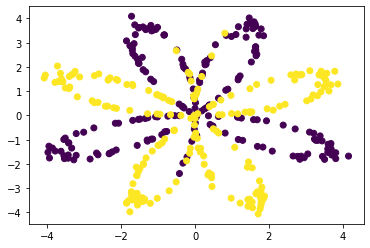

In [4]:
# Создаем и рисуем датасет в форме цветочка с 1000 объектов, цветами обозначены метки классов
X, Y = create_flower(400, 4)
plt.scatter(X[0, :], X[1, :], c=Y);

In [5]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Один нейрон

In [8]:
perceptron = Perceptron(X, Y, 1)
perceptron.learn(10000, 0.1)

MSE loss: 0.24219266939409137, CE loss: 0.6848429001814759
MSE loss: 0.21936019376604685, CE loss: 0.6307271779806437
MSE loss: 0.21860937984637707, CE loss: 0.6291202909652823
MSE loss: 0.21825432460424296, CE loss: 0.628354740233695
MSE loss: 0.2180388047837861, CE loss: 0.627888838278274
MSE loss: 0.2178904927967505, CE loss: 0.6275678685368767
MSE loss: 0.2177803890476664, CE loss: 0.6273294761665784
MSE loss: 0.21769438819749404, CE loss: 0.6271432444310275
MSE loss: 0.21762472152934323, CE loss: 0.6269923894234567
MSE loss: 0.21756672082237913, CE loss: 0.6268668122342832


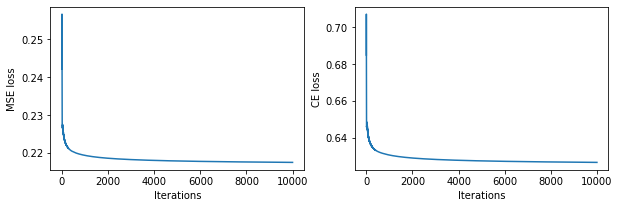

In [9]:
perceptron.plot()

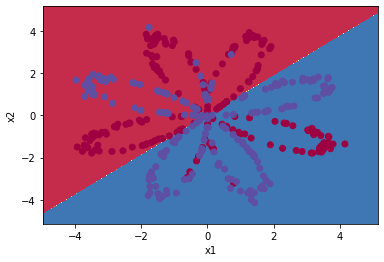

In [10]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
plot_division(perceptron)

### Четыре нейрона

In [11]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(10000, 0.1)

MSE loss: 0.261951229713305, CE loss: 0.7136564914789727
MSE loss: 0.0626852641587727, CE loss: 0.22558728324467325
MSE loss: 0.06048424279310319, CE loss: 0.2218315514538392
MSE loss: 0.06014946745158343, CE loss: 0.22302082268343218
MSE loss: 0.05944674304724124, CE loss: 0.22123259803355877
MSE loss: 0.05930263207593457, CE loss: 0.21735676800574752
MSE loss: 0.0589240302079085, CE loss: 0.21607872893144708
MSE loss: 0.05935914327801793, CE loss: 0.21777073900551727
MSE loss: 0.058733704851843205, CE loss: 0.2173345928971148
MSE loss: 0.05821337023734646, CE loss: 0.2172884381084117


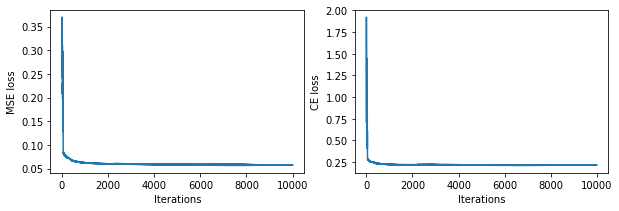

In [12]:
perceptron.plot()

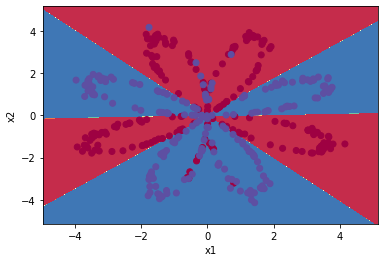

In [13]:
plot_division(perceptron)

### много нейронов - стало ли лучше?

In [6]:
perceptron = Perceptron(X, Y, 40)
perceptron.learn(10000, 0.1)

MSE loss: 0.44860640277649766, CE loss: 1.6044990158523635
MSE loss: 0.05801084773823293, CE loss: 0.5839718458379948
MSE loss: 0.04871759733246609, CE loss: 0.473280307299893
MSE loss: 0.050770438850447304, CE loss: 0.5213293393580967
MSE loss: 0.048338658101198924, CE loss: 0.4995500619867486
MSE loss: 0.04746299248506168, CE loss: 0.5393357046554461
MSE loss: 0.042450416075639506, CE loss: 0.5035145764567929
MSE loss: 0.04538428797639426, CE loss: 0.4292432109605829
MSE loss: 0.03782640190393685, CE loss: 0.40505480430708873
MSE loss: 0.04537888726550321, CE loss: 0.45215383030444517


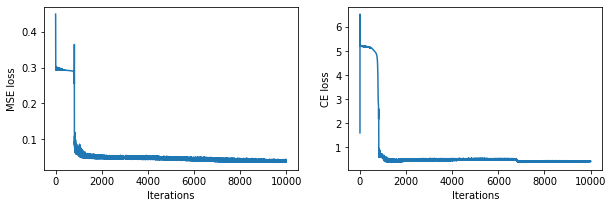

In [7]:
perceptron.plot()

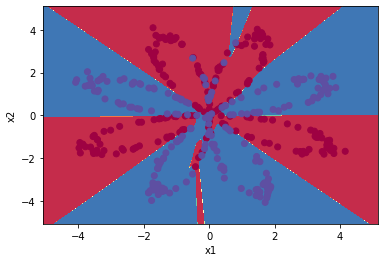

In [8]:
plot_division(perceptron)